# Implementation of Hinton's Forward-Forward Algorithm on CIFAR-10 using CNN

This notebook contains an implementation of Geoffrey Hinton's Forward-Forward Algorithm. Details about this algorithm can be found in Hinton's [paper](https://arxiv.org/abs/2212.13345#:~:text=The%20Forward%2DForward%20algorithm%20replaces,generated%20by%20the%20network%20itself).

(Incomplete) Demonstrated below is 4. Experiments with CIFAR-10
## Preparation:

- **Import Libraries:** Set up the coding environment with the required libraries.

## Definition of Necessary Functions and Classes:

- **A. Function to Generate Negative Labels:** Generate negative samples for training.

- **B. Function to Overlay Label onto the Input Data:** Overlay the correct class onto the input data for positive forward pass.

- **C. Custom Net Class:** Definition of the network using the custom forward-forward approach.

- **D. Custom Layer Class:** Definition of a custom layer class to be used in the network.

- **E. Network Hyperparameters and Device Setup:** Set the hyperparameters for the network and configure the computation device.

## Implementation Steps:

- **1. Load Data:** Load the MNIST dataset for training and testing.

- **2. Create Network:** Instantiate the network architecture.

- **3. Train the Network:** Train the network using the forward-forward algorithm.

- **4. Test the Network:** Test the network's performance on the MNIST test set.


### Import Libraries

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch.nn as nn
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, Normalize
from torch.utils.data import DataLoader
from torch.optim import Adam

### A. Function to generate negative labels

In [2]:
# Generates negative labels for the training data, which are required for contrastive divergence training
def get_y_neg(y):
    y_neg = y.clone()
    for idx, y_samp in enumerate(y):
        allowed_indices = list(range(10))
        allowed_indices.remove(y_samp.item())
        y_neg[idx] = torch.tensor(allowed_indices)[torch.randint(len(allowed_indices), size=(1,))].item()
    return y_neg.to(device)

### B. Function to overlay label onto the input data

In [3]:
# Overlays label info onto the input data, making a certain position in the tensor representative of the label
# experiment 1

def overlay_y_on_x(x, y, classes=10):
    
    # trial 6
    x_ = x.clone()
    x_[range(x.shape[0]), :, 0, :classes] *= 0.0
    x_[range(x.shape[0]), :, 0, y] = 1
    return x_
    
    '''
    # trial 5
    
    x_padded = nn.functional.pad(x, (0, 0, 1, 0))
    x_ = torch.zeros_like(x_padded)
    x_[range(x.shape[0]), :, 0, y] = 1.0  # set the pixel corresponding to the label of each individual image
    x_ += x_padded
    return x_
    '''
    
    '''
    # trial 4
    
    x_padded = nn.functional.pad(x, (0, 0, 1, 0))
    x_ = torch.zeros_like(x_padded)
    for i in range(x.size(0)):  # iterate over the batch dimension
        x_[i, :, 0, y[i]] = 1.0  # set the pixel corresponding to the label of each individual image
    x_ += x_padded
    return x_
    '''
    
    '''
    
    # trial 3
    
    x_padded = nn.functional.pad(x, (0, 0, 1, 0))
    x_ = torch.zeros_like(x_padded)
    x_[:, :, 0, y] = 1.0  # all batches, all channels, use 1.0 for white pixel in normalized dataset
    x_ += x_padded
    return x_
    
    
    '''
    
    '''
    # trial 2
    
    x_padded = nn.functional.pad(x, (0, 0, 1, 0))
    x_ = torch.zeros_like(x_padded)
    x_[:, 0, 0, y] = x.view(x.shape[0], -1).max(dim=1)[0]
    x_ += x_padded
    return x_
    
    '''
    
    '''
    # trial 1
    
    x_ = x.clone()
    x_[:, 0, :classes, :classes] *= 0.0
    x_[range(x.shape[0]), 0, y, y] = x.max()
    return x_
    '''

### C. Custom Net Class

In [4]:
# Define a Net class that inherits from torch.nn.Module which is the base class for all neural network modules in PyTorch.
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        '''
        
        # trial 10
        
        self.layers = nn.Sequential(
            Layer(3, 64, kernel_size=3, padding=1),  # Layer 0 
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            Layer(64, 64, kernel_size=3, padding=1),  # Layer 2
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=2, stride=2),  # Layer 4

            Layer(64, 128, kernel_size=3, padding=1),  # Layer 5 
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            Layer(128, 128, kernel_size=3, padding=1),  # Layer 7 
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=2, stride=2),  # Layer 9

            Layer(128, 256, kernel_size=3, padding=1),  # Layer 10
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            Layer(256, 256, kernel_size=3, padding=1),  # Layer 12
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            Layer(256, 256, kernel_size=3, padding=1),  # Layer 14 
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2),  # Layer 16

            Layer(256, 512, kernel_size=3, padding=1),  # Layer 17
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            Layer(512, 512, kernel_size=3, padding=1),  # Layer 19
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            Layer(512, 512, kernel_size=3, padding=1),  # Layer 21
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2),  # Layer 23

            Layer(512, 512, kernel_size=3, padding=1),  # Layer 24
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            Layer(512, 512, kernel_size=3, padding=1),  # Layer 26
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            Layer(512, 512, kernel_size=3, padding=1),  # Layer 28
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
        '''
        
    
        # trial 9
        
        self.layers = nn.Sequential(
            Layer(3, 64, kernel_size=5, padding=2),  # Layer 0
            nn.ReLU(inplace=True),

            Layer(64, 128, kernel_size=5, padding=2, stride=2),  # Layer 2
            nn.ReLU(inplace=True),

            Layer(128, 256, kernel_size=5, padding=2, stride=2),  # Layer 4
            nn.ReLU(inplace=True),

            Layer(256, 512, kernel_size=5, padding=2, stride=2),  # Layer 6
            nn.ReLU(inplace=True),

            Layer(512, 1024, kernel_size=5, padding=2, stride=2),  # Layer 8
            nn.ReLU(inplace=True),

            Layer(1024, 2048, kernel_size=5, padding=2, stride=2),  # Layer 10
            nn.ReLU(inplace=True),

            Layer(2048, 10, kernel_size=1, stride=1),  # Layer 12
            nn.ReLU(inplace=True),
        )
        
        
 
        '''
        # trial 8
        
        self.layers = nn.Sequential(
            Layer(3, 64, kernel_size=3, padding=1),  # Layer 0 
            nn.ReLU(inplace=True),
            Layer(64, 64, kernel_size=3, padding=1),  # Layer 2
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=2, stride=2),  # Layer 4

            Layer(64, 128, kernel_size=3, padding=1),  # Layer 5 
            nn.ReLU(inplace=True),
            Layer(128, 128, kernel_size=3, padding=1),  # Layer 7 
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=2, stride=2),  # Layer 9

            Layer(128, 256, kernel_size=3, padding=1),  # Layer 10
            nn.ReLU(inplace=True),
            Layer(256, 256, kernel_size=3, padding=1),  # Layer 12
            nn.ReLU(inplace=True),
            Layer(256, 256, kernel_size=3, padding=1),  # Layer 14 
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2),  # Layer 16

            Layer(256, 512, kernel_size=3, padding=1),  # Layer 17
            nn.ReLU(inplace=True),
            Layer(512, 512, kernel_size=3, padding=1),  # Layer 19
            nn.ReLU(inplace=True),
            Layer(512, 512, kernel_size=3, padding=1),  # Layer 21
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2),  # Layer 23

            Layer(512, 512, kernel_size=3, padding=1),  # Layer 24
            nn.ReLU(inplace=True),
            Layer(512, 512, kernel_size=3, padding=1),  # Layer 26
            nn.ReLU(inplace=True),
            Layer(512, 512, kernel_size=3, padding=1),  # Layer 28
            nn.ReLU(inplace=True)
        )
        
        '''      
        
        '''
        # trial 7
        
        self.layers = nn.Sequential(
        Layer(3, 64, kernel_size=5, padding=2),  # Layer 0 with 5x5 receptive field
        nn.ReLU(inplace=True),

        Layer(64, 128, kernel_size=5, padding=2, stride=2),  # Layer 2 with 5x5 receptive field
        nn.ReLU(inplace=True),

        Layer(128, 256, kernel_size=5, padding=2, stride=2),  # Layer 4 with 5x5 receptive field
        nn.ReLU(inplace=True),

        Layer(256, 10, kernel_size=1, stride=1),  # Layer 6 with 1x1 receptive field
        nn.ReLU(inplace=True),
        )
        
        '''
        
        '''
        # trial 6
        
        self.layers = nn.Sequential(
        Layer(3, 3, kernel_size=11, padding=5),  # Layer 1 with 11x11 receptive field
        nn.ReLU(inplace=True),
        Layer(3, 3, kernel_size=11, padding=5),  # Layer 2 with 11x11 receptive field
        nn.ReLU(inplace=True),
        Layer(3, 3, kernel_size=11, padding=5),  # Layer 3 with 11x11 receptive field
        nn.ReLU(inplace=True),
        nn.Flatten(),  # Flatten the output
        FullyConnectedLayer(3 * 32 * 32, 10),  # Fully connected layer with 3072 inputs and 10 outputs
        )
        '''
        
              
        '''
        # trial 5
        
        self.layers = nn.Sequential(
        Layer(3, 32, kernel_size=11, padding=1),  # Conv 1 with kernel size 11x11
        nn.ReLU(inplace=True),
        Layer(32, 32, kernel_size=9, padding=1),  # Conv 2 with kernel size 11x11
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        Layer(32, 64, kernel_size=4, padding=1),  # Conv 3 with kernel size 11x11
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        FullyConnectedLayer(128 * 3 * 3, 500),  # Adjusted input dimension
        nn.ReLU(inplace=True),
        FullyConnectedLayer(500, 500),
        nn.ReLU(inplace=True),
        FullyConnectedLayer(500, 10)
        )
        '''

        '''
        # trial 4
        
        self.layers = nn.Sequential(
        Layer(3, 32, kernel_size=11, padding=1),  # Conv 1
        nn.ReLU(inplace=True),
        Layer(32, 32, kernel_size=11, padding=1),  # Conv 2
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        Layer(32, 64, kernel_size=5, padding=1),  # Conv 3
        nn.ReLU(inplace=True),
        Layer(64, 64, kernel_size=5, padding=1),  # Conv 4
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        Layer(64, 128, kernel_size=3, padding=1),  # Conv 5
        nn.ReLU(inplace=True),
        Layer(128, 128, kernel_size=3, padding=1),  # Conv 6
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        FullyConnectedLayer(128 * 4 * 4, 500),  # Note: If the dimensions don't match, adjust the first dimension here
        nn.ReLU(inplace=True),
        FullyConnectedLayer(500, 500),
        nn.ReLU(inplace=True),
        FullyConnectedLayer(500, 10)
        )
        '''
        
        '''
        # trial 3  
        self.layers = nn.Sequential(
        Layer(3, 32, kernel_size=3, padding=1),  # Conv 1
        nn.ReLU(inplace=True),
        Layer(32, 32, kernel_size=3, padding=1),  # Conv 2
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        Layer(32, 64, kernel_size=3, padding=1),  # Conv 3
        nn.ReLU(inplace=True),
        Layer(64, 64, kernel_size=3, padding=1),  # Conv 4
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        Layer(64, 128, kernel_size=3, padding=1),  # Conv 5
        nn.ReLU(inplace=True),
        Layer(128, 128, kernel_size=3, padding=1),  # Conv 6
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        FullyConnectedLayer(128 * 4 * 4, 500),  # Note: If the dimensions don't match, adjust the first dimension here
        nn.ReLU(inplace=True),
        FullyConnectedLayer(500, 500),
        nn.ReLU(inplace=True),
        FullyConnectedLayer(500, 10)
        )
        '''
        
        '''
        # trial 2
        
        self.layers = nn.Sequential(
        Layer(3, 32, kernel_size=3, padding=1),  # Conv 1
        nn.ReLU(inplace=True),
        Layer(32, 32, kernel_size=3, padding=1),  # Conv 2
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        Layer(32, 64, kernel_size=3, padding=1),  # Conv 3
        nn.ReLU(inplace=True),
        Layer(64, 64, kernel_size=3, padding=1),  # Conv 4
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        Layer(64, 128, kernel_size=3, padding=1),  # Conv 5
        nn.ReLU(inplace=True),
        Layer(128, 128, kernel_size=3, padding=1),  # Conv 6
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        FullyConnectedLayer(128 * 4 * 4, 500),
        nn.ReLU(inplace=True),
        FullyConnectedLayer(500, 500),
        nn.ReLU(inplace=True),
        FullyConnectedLayer(500, 10)
        )
        
        '''

        '''
        # trial 1

        self.layers = nn.Sequential(
        Layer(3, 32, kernel_size=3, padding=1),
        nn.MaxPool2d(2, 2),
        Layer(32, 64, kernel_size=3, padding=1),
        nn.MaxPool2d(2, 2),
        nn.Flatten(),
        FullyConnectedLayer(4096, 500),  # use new FullyConnectedLayer
        FullyConnectedLayer(500, 500),
        FullyConnectedLayer(500, 10),
        )
        
        '''

    def forward(self, x):
        return self.layers(x)

    def predict(self, x):
        goodness_per_label = []
        for label in range(10):
            h = overlay_y_on_x(x, label)
            goodness = []
            for layer in self.layers:
                h = layer(h)
                goodness += [(h.pow(2).sum() / h.numel()).unsqueeze(0)]
            goodness_per_label += [torch.sum(torch.stack(goodness)).unsqueeze(0)]
        goodness_per_label = torch.cat(goodness_per_label, 0)
        return goodness_per_label.argmax(0)

    def custom_train(self, x_pos, x_neg):
        h_pos, h_neg = x_pos, x_neg
        for i, layer in enumerate(self.layers):
            print("training layer: ", i)
            if isinstance(layer, Layer):  # only call custom_train on instances of the Layer class
                h_pos, h_neg = layer.custom_train(h_pos, h_neg)
            elif isinstance(layer, FullyConnectedLayer):  # only call custom_train on instances of the FullyConnectedLayer class
                h_pos, h_neg = layer.custom_train(h_pos, h_neg)
            else:  # for other layers, just pass the data through
                h_pos = layer(h_pos)
                h_neg = layer(h_neg)

### D1. Custom Fully Connected Layer Class

In [5]:
# Fully Connected layers of the network.
class FullyConnectedLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True, final_layer=False):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        self.relu = nn.ReLU()
        self.opt = Adam(self.parameters(), lr=args.lr)
        self.fcl_threshold = args.fcl_threshold
        self.num_epochs = args.epochs
        self.final_layer = final_layer

    def forward(self, x):
        #L2 norm
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)
        return self.relu(self.linear(x_direction))

    def custom_train(self, x_pos, x_neg):
        for i in range(self.num_epochs):
            g_pos = self.forward(x_pos).pow(2).mean().unsqueeze(0)  # mean over all dimensions in a sample
            g_neg = self.forward(x_neg).pow(2).mean().unsqueeze(0)  # mean over all dimensions in a sample
            loss = torch.log(1 + torch.exp(torch.cat([-g_pos + self.fcl_threshold, g_neg - self.fcl_threshold]))).mean()
            self.opt.zero_grad()
            loss.backward()
            self.opt.step()
            if i % args.log_interval == 0:
                print("Loss: ", loss.item())
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()

### D2. Custom Convolutional Layer Class

In [6]:
# Convolutional layers of the network.
class Layer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0, bias=True, final_layer=False):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias)
        self.relu = nn.ReLU()
        self.opt = Adam(self.parameters(), lr=args.lr)
        self.conv_threshold = args.conv_threshold
        self.num_epochs = args.epochs
        self.final_layer = final_layer

    def forward(self, x):
        
        '''
        # trial 10
        # batch norm
        x = self.conv(x)
        return self.relu(x) 
        '''
        
        # L2 norm
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)
        return self.relu(self.conv(x_direction))           

    def custom_train(self, x_pos, x_neg):
        
        # initialize lists to hold values
        loss_values = []
        g_pos_values = []
        g_neg_values = []

        # initialize figure
        fig = plt.figure(figsize=(12,8))
        
        for i in range(self.num_epochs):
            g_pos = self.forward(x_pos).pow(2).mean(dim=(1,2,3)).unsqueeze(0)  # mean over all dimensions
            g_neg = self.forward(x_neg).pow(2).mean(dim=(1,2,3)).unsqueeze(0)  # mean over all dimensions
            loss = torch.log(1 + torch.exp(torch.cat([-g_pos + self.conv_threshold, g_neg - self.conv_threshold]))).mean()
            self.opt.zero_grad()
            
            #loss.backward()
            loss.backward(retain_graph=True)

            self.opt.step()
            
            if i % args.log_interval == 0:
                loss_values.append(loss.item())
                g_pos_values.append(g_pos.mean().item())  # take mean of all batch values
                g_neg_values.append(g_neg.mean().item())  # take mean of all batch values

                # plotting
                plt.subplot(3,1,1)
                plt.plot(loss_values, color='blue')
                plt.title("Loss during training")

                plt.subplot(3,1,2)
                plt.plot(g_pos_values, color='green')
                plt.title("g_pos during training")

                plt.subplot(3,1,3)
                plt.plot(g_neg_values, color='red')
                plt.title("g_neg during training")

                plt.tight_layout()
                clear_output(wait=True)  # this clears the output of the cell, useful for updating the plots
                plt.show()

            # Print the loss at each step
            print(f'Loss at step {i}: {loss.item()}')
            
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()

### E. Network Hyperparameters and device setup

In [7]:
class Args:
    train_size = 1000 #10000 #50000
    test_size = 100 #2000 #10000
    epochs = 1000
    lr = 0.05
    no_cuda = False
    no_mps = False
    save_model = False
    fcl_threshold = 1
    conv_threshold = 0.02
    seed = 1234
    log_interval = 10

args = Args()
use_cuda = not args.no_cuda and torch.cuda.is_available()
use_mps = not args.no_mps and torch.backends.mps.is_available()
if use_cuda:
    device = torch.device("cuda")
elif use_mps:
    device = torch.device("mps")
else:
    device = torch.device("cpu")
train_kwargs = {"batch_size": args.train_size}
test_kwargs = {"batch_size": args.test_size}
if use_cuda:
    cuda_kwargs = {"num_workers": 1, "pin_memory": True, "shuffle": True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

### 1. Load data

In [8]:
# Load Data
transform = Compose(
    [
        ToTensor(),
        Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

train_loader = DataLoader(CIFAR10("./data/", train=True, download=True, transform=transform), **train_kwargs)
test_loader = DataLoader(CIFAR10("./data/", train=False, download=True, transform=transform), **test_kwargs)

Files already downloaded and verified
Files already downloaded and verified


### 2. Create network

In [9]:
# Create Model
net = Net().to(device)

### 3. Train the network

In [10]:
x, y = next(iter(train_loader))
x, y = x.to(device), y.to(device)
x_pos = overlay_y_on_x(x, y)
y_neg = get_y_neg(y)
x_neg = overlay_y_on_x(x, y_neg)

### Inspect Tensors

In [11]:
x.size()

torch.Size([1000, 3, 32, 32])

In [12]:
x.size(0)

1000

In [13]:
y.size()

torch.Size([1000])

### Visualize Samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

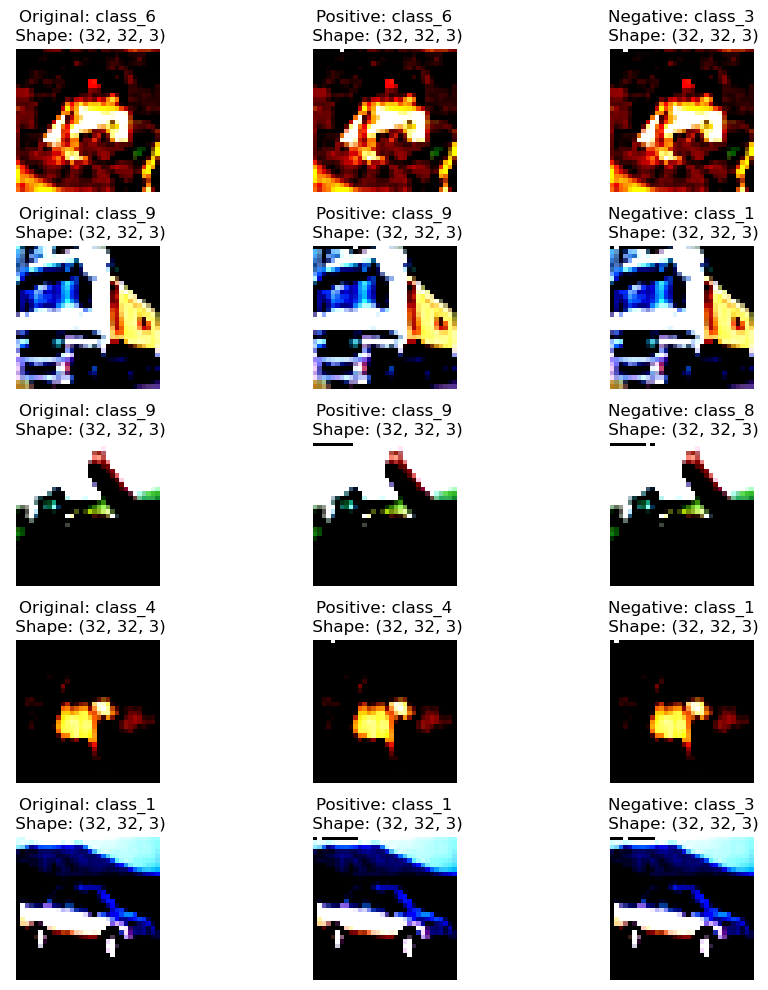

In [14]:
fig, axs = plt.subplots(5, 3, figsize=(10, 10))

# Define a dictionary to map class indices to class names (replace this with your actual classes)
class_dict = {i: 'class_' + str(i) for i in range(10)}

for i in range(5):
    img = x[i].cpu().numpy().transpose(1,2,0)
    pos_img = x_pos[i].cpu().numpy().transpose(1,2,0)
    neg_img = x_neg[i].cpu().numpy().transpose(1,2,0)

    axs[i, 0].imshow(img)
    axs[i, 0].set_title('Original: ' + class_dict[int(y[i])] + '\n Shape: ' + str(img.shape))
    
    axs[i, 1].imshow(pos_img)
    axs[i, 1].set_title('Positive: ' + class_dict[int(y[i])] + '\n Shape: ' + str(pos_img.shape))
    
    axs[i, 2].imshow(neg_img)
    axs[i, 2].set_title('Negative: ' + class_dict[int(y_neg[i])] + '\n Shape: ' + str(neg_img.shape))

for ax in axs.flat:
    ax.axis('off')

plt.tight_layout()  # Adjusts subplot params so that subplots are nicely fit in the figure
plt.show()

### Train the Network

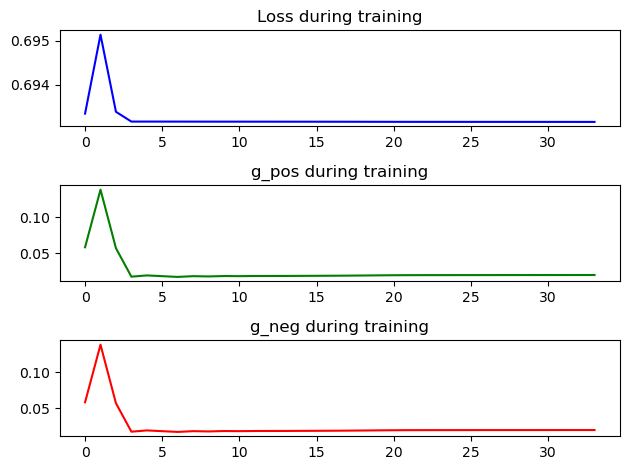

Loss at step 330: 0.6931453943252563
Loss at step 331: 0.6931452751159668
Loss at step 332: 0.6931452751159668
Loss at step 333: 0.6931452751159668


In [ ]:
net.custom_train(x_pos, x_neg)

In [ ]:
print("Train Accuracy: {:.2f}%".format(100 * net.predict(x).eq(y).float().mean().item()))

### 4. Test the Network

In [ ]:
# Test Model
x_te, y_te = next(iter(test_loader))
x_te, y_te = x_te.to(device), y_te.to(device)
if args.save_model:
    torch.save(net.state_dict(), "cifar10_ff.pt")

In [ ]:
print("Test Accuracy: {:.2f}%".format(100 * net.predict(x_te).eq(y_te).float().mean().item()))